# Weekly Challenge 06

*Original URL* https://community.alteryx.com/t5/Weekly-Challenge/Challenge-6-Spatial-Route/td-p/36733 and [**My Alteryx Approach**](https://github.com/dsmdavid/Alteryx-Weekly-Challenge/tree/master/submitted/sub_Challenge%2306)

## Brief

The challenge for week 6 will focus on analyzing distance traveled by sales reps.


Sales reps are travelling all over the US. The data contained in the workflow details the travel paths for 7 Reps to 7 different cities. The travel route is detailed as well. The objective of this challenge is to determine which Rep has logged the most miles. Please include the route traveled as a spatial object in the output.


## Approach I want to follow:
1. Read the data.
1. Calculate the distance between each point and the next and sum.
1. Combine the points in order for each repr and print the route.

In [1]:
import geopandas
from shapely.geometry import LineString
from geopy.distance import geodesic, great_circle, lonlat
import pandas as pd

%matplotlib inline

In [2]:
#read data
df = geopandas.read_file("./06_files/input.shp")
df.head()

,Airport_Ci,REP,TripOrder,geometry
0,"Hartford-West Hartford-East Hartford, CT Metro",Cathy,1,POINT (-72.577485 41.735909)
1,"Indianapolis-Carmel-Anderson, IN Metro",Cathy,2,POINT (-86.206137 39.747431)
2,"Springfield, MA Metro",Cathy,3,POINT (-72.64674100000001 42.230068)
3,"Reno, NV Metro",Cathy,4,POINT (-119.660656 40.638609)
4,"Cleveland-Elyria, OH Metro",Cathy,5,POINT (-81.683882 41.375258)


In [3]:
def to_geopy(point):
    '''Geopandas uses (longitude, latitude); whereas geopy uses (latitude, longitude). This parses
    geopandas/shapely points into geopy points to use them in the distance calculator'''
    return lonlat(point.x, point.y)

def distance_point_gp(point1, point2,dist_type='geodesic'):
    '''returns geodesic distance when using geopy points'''
    if dist_type == 'great_circle':
        return great_circle(point1, point2).miles
    else:
        return geodesic(point1,point2).miles
    
def get_distance(df, rep, dist_type):
    temp = df[df['REP']==rep].copy()
    temp['next'] = temp['point'].shift(1)
    temp['distance'] = temp[temp['next'].isnull()==False][['point','next']].apply(lambda x: distance_point_gp(x['point'], x['next'], dist_type), axis =1)
    return temp['distance'].sum()

def get_routes(df):
    ##Get the routes as lines##
    df2 = df.dissolve(by='REP')
    #Create the polyline
    df2['line'] = df2['geometry'].apply(LineString)
    #Set the new line as the active geometry
    df2 = df2.set_geometry('line') 
    #Keep only relevant columns
    return df2.join(df_distances)[['line','distance']].sort_values(by='distance', ascending=False).reset_index()
    

In [4]:
df['point'] = df['geometry'].apply(to_geopy) #get_geopy_points

distances = {} 
dist_type = 'geodesic' ##change to 'great_circle' or 'geodesic'

# I'm pretty sure this ##Calculate the distance traveled by each rep and add it to the dictionary## 
# is easier done with some groupby, but don't know how
for rep in df['REP']: 
    distances[rep] = get_distance(df, rep, dist_type)

df_distances = pd.DataFrame.from_dict(distances, orient='index')
df_distances.columns = ['distance']
df_distances.sort_values(by='distance', ascending=False, inplace=True)
df_distances


,distance
Diana,9101.343658
Cathy,6794.737789
Dan,6230.891198
James,6172.646807
Steve,4259.534776
Scott,4189.106581
Mark,3215.240449


     REP                                               line     distance
0  Diana  LINESTRING (-121.847665 47.557175, -118.149366...  9101.343658
1  Cathy  LINESTRING (-119.660656 40.638609, -89.591695 ...  6794.737789
2    Dan  LINESTRING (-112.070554 33.185508, -106.471533...  6230.891198
3  James  LINESTRING (-122.846159 43.938519, -113.041258...  6172.646807
4  Steve  LINESTRING (-104.689616 41.307065, -97.503812 ...  4259.534776
5  Scott  LINESTRING (-104.893931 39.433975, -96.9900740...  4189.106581
6   Mark  LINESTRING (-94.123458 36.194649, -92.309235 3...  3215.240449


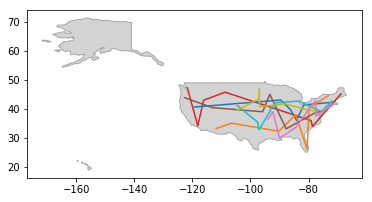

In [5]:
df3 = get_routes(df)
print(df3)
##Plot the lines using the US background

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world[world['name']=='United States'].plot(color='lightgrey', edgecolor='darkgrey')
df3.plot(ax=base, column='REP')
